## High-level settings, imports

In [1]:
import os
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torchvision.datasets import MNIST, FashionMNIST

n_epochs = 10
batch_size = 64
image_shape = (1, 28, 28)
output_classes = 10
device = 'cuda'
results_dir = os.path.join('.', 'results', 'mnist_antigan_features', 'trial_0')
digitize_bits = None
dataset = FashionMNIST
dataset_path = os.path.join('.', 'saved_datasets', 'FashionMNIST')

## Initialize discriminator model

## Initialize datasets and dataloaders

In [2]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose

training_dataset = dataset(
    root=dataset_path,
    train=True,
    download=False,
    transform=Compose((ToTensor(), Normalize(mean=(0.5,), std=(0.5,)))))
testing_dataset = dataset(
    root=dataset_path,
    train=False,
    download=False,
    transform=Compose((ToTensor(), Normalize(mean=(0.5,), std=(0.5,)))))
training_dataloader = DataLoader(training_dataset, shuffle=True, batch_size=batch_size)
testing_dataloader = DataLoader(testing_dataset, shuffle=False, batch_size=batch_size)

## Load trained generator

In [3]:
from models.lenet_gan import SimpleGen

gen = SimpleGen(
    latent_dims=100,
    label_dims=10,
    output_shape=(batch_size, *image_shape),
    output_classes=10)
gen.load_state_dict(torch.load(os.path.join(results_dir, 'trained_generator')))
gen.eval()

print(gen)

SimpleGen(
  (feature_encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU()
  )
  (label_encoder): Sequential(
    (0): Embedding(10, 10)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=9, bias=True)
  )
  (latent_encoder): Sequential(
    (0): Linear(in_features=100, out_features=216, bias=True)
    (1): ReLU()
    (2): Linear(in_features=216, out_features=108, bias=True)
  )
  (feature_decoder): Sequential(
    (0): ConvTranspose2d(45, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 

## Define training functions

In [26]:
from models.lenet5 import LeNet5

def digitize_image(image):
    image = 255*(.5*image+.5)
    image = image.to(torch.uint8)
    image = image.to(torch.float32)
    image = 2*(image/255)-1
    return image

def get_protected_images(images, labels, override_device=None):
    if override_device is not None:
        latent = torch.randn(batch_size, 100, device=override_device)
        from copy import deepcopy
        gen_dev = deepcopy(gen).to(override_device)
        masks = gen_dev(latent, labels, images)
    else:
        latent = torch.randn(batch_size, 100, device=device)
        masks = gen(latent, labels, images)
    protected_images = torch.tanh(images + nn.functional.hardtanh(masks))
    protected_images = digitize_image(protected_images)
    return protected_images

def get_noisy_images(images, *args, override_device=None):
    if override_device is not None:
        noise = 2*torch.rand(images.shape, device=override_device)-1
    else:
        noise = 2*torch.rand(images.shape, device=device)-1
    noisy_images = torch.tanh(images + noise)
    noisy_images = digitize_image(noisy_images)
    return noisy_images

def process_batch(batch, process_image_fn=None, override_device=None):
    images, labels = batch
    images = images.to(override_device if override_device is not None else device)
    labels = labels.to(override_device if override_device is not None else device)
    if process_image_fn is not None:
        images = process_image_fn(images, labels, override_device=override_device)
    return images, labels

def train_step(disc, loss_fn, optimizer, batch, process_image_fn=None):
    images, labels = process_batch(batch, process_image_fn)
    logits = disc(images)
    loss = loss_fn(logits, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

@torch.no_grad()
def eval_step(disc, loss_fn, batch, process_image_fn=None, override_device=None):
    images, labels = process_batch(batch, process_image_fn, override_device=override_device)
    logits = disc(images)
    loss = loss_fn(logits, labels).cpu().numpy()
    predictions = np.argmax(logits.cpu().numpy(), axis=-1)
    acc = np.mean(np.equal(predictions, labels.cpu().numpy()))
    return loss, acc

def train_epoch(disc, loss_fn, optimizer, dataloader, process_image_fn=None):
    for batch in dataloader:
        train_step(disc, loss_fn, optimizer, batch, process_image_fn=process_image_fn)

def eval_epoch(disc, loss_fn, dataloader, process_image_fn=None, override_device=None):
    losses, accs = [], []
    for batch in dataloader:
        loss, acc = eval_step(disc, loss_fn, batch, process_image_fn=process_image_fn, override_device=override_device)
        losses.append(loss)
        accs.append(acc)
    return np.mean(losses), np.mean(accs)

def train_disc(process_image_fn=None):
    disc = LeNet5(
        input_shape=(batch_size, *image_shape),
        output_classes=10).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(disc.parameters())
    
    train_losses, train_accs, test_losses, test_accs = [], [], [], []
    progress_bar = tqdm(total=3*n_epochs+2)
    def eval_performance():
        nonlocal train_losses, train_accs, test_losses, test_accs
        train_loss, train_acc = eval_epoch(disc, loss_fn, training_dataloader, process_image_fn=process_image_fn)
        progress_bar.update(1)
        test_loss, test_acc = eval_epoch(disc, loss_fn, testing_dataloader, process_image_fn=process_image_fn)
        progress_bar.update(1)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
    eval_performance()
    for epoch in range(n_epochs):
        train_epoch(disc, loss_fn, optimizer, training_dataloader, process_image_fn=process_image_fn)
        progress_bar.update(1)
        eval_performance()
    return np.array(train_losses), np.array(train_accs), np.array(test_losses), np.array(test_accs), disc

def display_disc_performance(process_image_fn=None):
    train_losses, train_accs, test_losses, test_accs, disc = train_disc()
    (fig, axes) = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].plot(train_losses, '--', color='blue', label='Training losses')
    axes[0].plot(test_losses, '-', color='blue', label='Testing losses')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss over time')
    axes[0].legend()
    axes[0].grid(True)
    axes[1].plot(1-train_accs, '--', color='blue', label='Training accuracies')
    axes[1].plot(1-test_accs, '-', color='blue', label='Testing accuracies')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Error rate')
    axes[1].set_title('Error rate over time')
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].grid(True)
    fig.suptitle('Independent discriminator performance: {}'.format(process_image_fn))
    plt.tight_layout()
    return disc

def display_images(process_image_fn=None):
    batch = next(iter(testing_dataloader))
    images, labels = batch
    if process_image_fn is not None:
        images = process_image_fn(images, labels, override_device='cpu')
    images_to_show = {}
    for idx in range(10):
        for label, image in zip(labels, images):
            if label == idx:
                images_to_show[idx] = image
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    for ax, (label, image) in zip(axes.flatten(), images_to_show.items()):
        ax.imshow(np.transpose(image.numpy(), (1, 2, 0)), cmap='binary', aspect='equal', interpolation='none')
        ax.set_title('Label: {}'.format(label))
    plt.tight_layout()

## Train discriminator on noise-free data

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [02:43<00:00,  5.12s/it]


Clean discriminator loss: 1.5691773891448975, acc: 0.8923168789808917


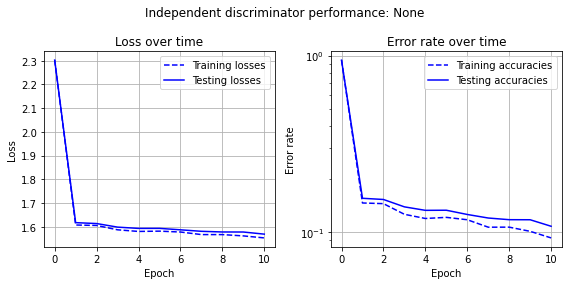

In [5]:
clean_disc = display_disc_performance()
loss, acc = eval_epoch(clean_disc, nn.CrossEntropyLoss(), testing_dataloader)
print('Clean discriminator loss: {}, acc: {}'.format(loss, acc))

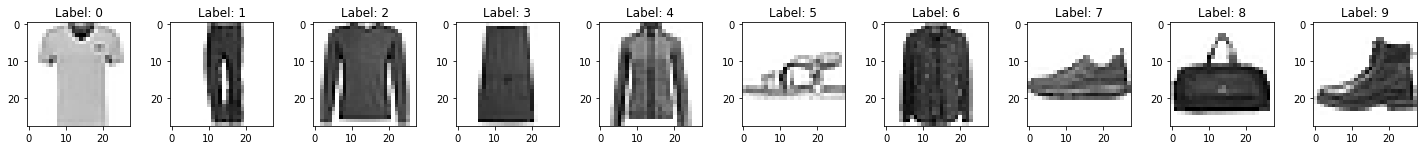

In [6]:
display_images()

## Train discriminator on data with uniform noise

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [02:43<00:00,  5.12s/it]


Clean discriminator loss: 1.6574796438217163, acc: 0.8030453821656051


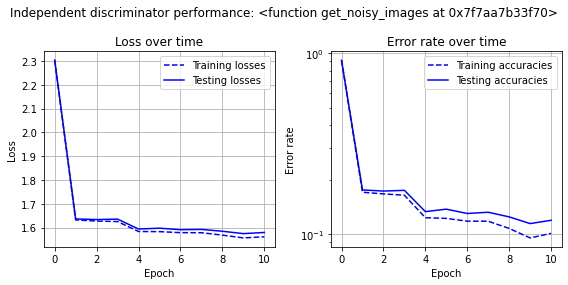

In [7]:
display_disc_performance(get_noisy_images)

Clean discriminator loss: 1.6607253551483154, acc: 0.7983678343949044


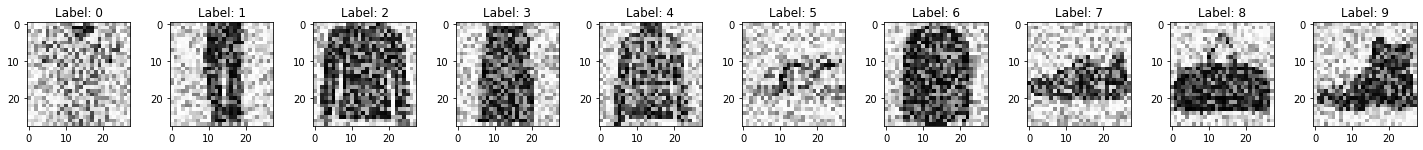

In [13]:
display_images(get_noisy_images)
loss, acc = eval_epoch(clean_disc, nn.CrossEntropyLoss(), testing_dataloader, get_noisy_images)
print('Clean discriminator loss: {}, acc: {}'.format(loss, acc))

## Train discriminator on data with generated mask

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [02:43<00:00,  5.11s/it]


Clean discriminator loss: 1.6614173650741577, acc: 0.7983678343949044


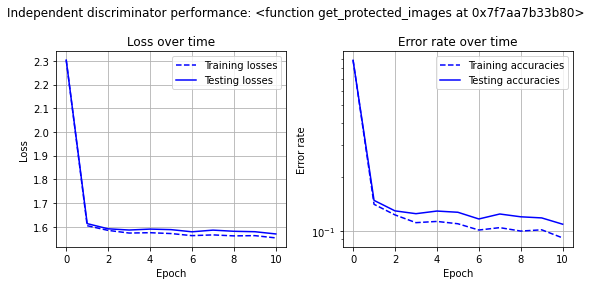

In [9]:
display_disc_performance(get_protected_images)

Clean discriminator loss: 2.175847053527832, acc: 0.27856289808917195


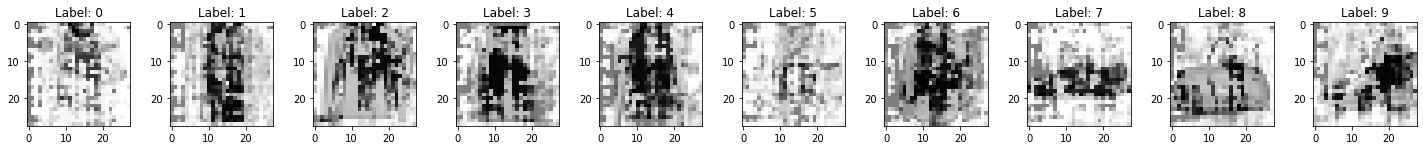

In [28]:
display_images(get_protected_images)
clean_disc = clean_disc.to('cpu')
loss, acc = eval_epoch(clean_disc, nn.CrossEntropyLoss(), testing_dataloader, get_protected_images, override_device='cpu')
print('Clean discriminator loss: {}, acc: {}'.format(loss, acc))